**Introduction.**

The `Earth-Move, (EM)` distance or `Wasserstein_1` distance, between the distributions $p, q$ is defined as
$$ d_W(p, q) = \inf_{\tau \in J(p, q)} \mathbb{E}_{(X, Y) \sim \tau} \Vert X - Y \Vert. $$
where $J(p, q)$ is the set of (probability) distributions $\tau(x, y)$ whose marginals are respectively $p, q.$

In case the 1D-distributions, then the previous formula becomes
$$ d_W(p, q) = \inf_{\tau \in J(p, q)} \mathbb{E}_{(X, Y) \sim \tau} \vert X - Y \vert. $$

Intuitively, the terms $\tau(x, y)$ indicates how much *`mass`* must be transported from $x$ to $y$ in order to transform the distribution $p$ to $q$. So, this distance is also knowns as the `EM`distance since it can be seen as the minimum amount of `“work”` required to transform $p$ into $q$; where the `“work”` is measured as the amount of distribution weight that must be moved, multiplied by the distance it has to be moved.

Recall that, we defined $W_K$ distance as
$$ d_{W_K}(\mu, \nu) = \left( \inf_{\tau \in J(p, q)} \mathbb{E}_{(X, Y) \sim \tau} \Vert X - Y \Vert^K \right)^{1/K}. $$

In [1]:
from scipy.stats import wasserstein_distance as ssw
import numpy as np
import matplotlib.pyplot as plt

**Example 1.** Use the function `wasserstein_distance` in `scipy.stats` to `approximate` the EM distance between 2 *independent* `uniform distributions`, such as $U([1, 2])$ and $U([0, 1])$.

*Note that this function only using for calculating the distance of 1D distributions.*
Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html#scipy.stats.wasserstein_distance

In [2]:
# Fix the range of values
x = np.linspace(-5, 5, 10)

# Generate the empirical distribution values of the 2 uniform distributions
p = np.random.uniform(1, 2, 1000)
q = np.random.uniform(0, 1, 1000)

# Approximate the W1_distance
ssw(p, q)

0.9953392439128976

**Explain EX1.** There is only one possible coupling of these two measures, that is $\tau(x, y) \sim U([0, 1] \times [1, 2])$ and hence we get
$$d_W(p, q) = \int_0^1 \int_1^2 |x - y| dy dx = 1.$$

**Example 2.** Now, we will work now with `discrete uniform distributions` in 2D space (instead of 1D space as above). Let $Z \sim U([0, 1]), p$ be the distribution of $(0, Z)$ and $q$ be the distribution of $(\eta, Z).$

This is easy to check that the EM distance  between them is equal to $\vert \eta \vert$.

First, look at the illustration bellow, $p, q$ are uniform on the straight vertical line passing the origin and the point $\theta$ respectively.

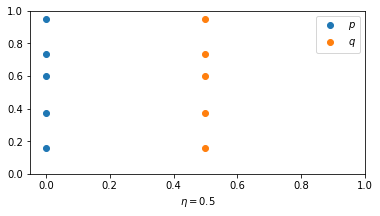

In [3]:
np.random.seed(42)
eta = 0.5
n_points = 5

Z = np.random.uniform(0,1, n_points)
p = np.array([[0, z] for z in Z ])
q = np.array([[eta, z] for z in Z ])

plt.figure(figsize=(6, 3))
plt.scatter(p[:, 0], p[:, 1], label='$p$')
plt.scatter(q[:, 0], q[:, 1], label='$q$')
plt.xlabel('$\eta = $' + str(eta))
plt.legend(loc = 'upper right');
plt.axis([-0.05, 1, 0, 1])
plt.show()

Now we will approximate this distance by the empirical distribution.

In [4]:
p = np.array([[0, z] for z in Z ])
q = np.array([[eta, z] for z in Z ])

# calculate the distance for 2D distributions
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
d = cdist(p, q)
assignment = linear_sum_assignment(d)
print(d[assignment].sum() / n_points)

0.5


Next, I take $\theta \in [-1, 1]$

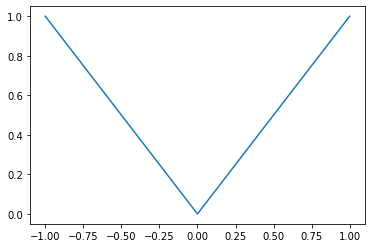

In [5]:
Theta = [-1, -0.2, 0, 0.25, 1]
n_points = 500
D_Theta = []
for theta in Theta:
    Z = np.random.uniform(0,1, n_points)
    p = np.array([[0, z] for z in Z ])
    q = np.array([[theta, z] for z in Z ])
    d = cdist(p, q)
    d_theta = d[linear_sum_assignment(d)].sum() / n_points
    D_Theta.append(d_theta)

plt.plot(Theta, D_Theta)

**A simple example in `W-GAN`**

In [6]:
import torch
import time
import torch.nn
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

8


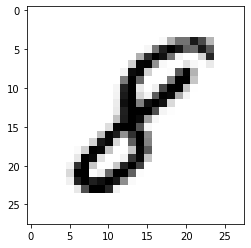

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
image_index = 7777 # You may select anything up to 60,000
print(y_train[image_index]) # The label is 8
plt.imshow(x_train[image_index], cmap='Greys')

In [8]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot

Using TensorFlow backend.


In [10]:
mb_size = 32
z_dim = 10
h_dim = 128
cnt = 0
lr = 1e-4

In [11]:
# clip model weights to a given hypercube
class ClipConstraint(Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

In [12]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)

In [13]:
# define the standalone critic model
def define_critic(in_shape=(28,28,1)):
    
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # weight constraint
    const = ClipConstraint(0.01)
    
    # define model
    model = Sequential()
    
    # downsample to 14x14
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', 
                     kernel_initializer=init, kernel_constraint=const, 
                     input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample to 7x7
    model.add(Conv2D(64, (4,4), strides=(2,2), padding='same', 
                     kernel_initializer=init, kernel_constraint=const))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # scoring, linear activation
    model.add(Flatten())
    model.add(Dense(1))
    
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    
    return model

In [14]:
# define the standalone generator model
def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # define model
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, kernel_initializer=init, 
                    input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), 
                              padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), 
                              padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # output 28x28x1
    model.add(Conv2D(1, (7,7), activation='tanh', 
                     padding='same', kernel_initializer=init))
    return model

In [15]:
# define the combined generator and critic model, for updating the generator
def define_gan(generator, critic):
    
    # make weights in the critic not trainable
    critic.trainable = False
    
    # connect them
    model = Sequential()
    
    # add generator
    model.add(generator)
    
    # add the critic
    model.add(critic)
    
    # compile model
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    
    return model

In [16]:
# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # select all of the examples for a given class
    selected_ix = trainy == 7
    X = trainX[selected_ix]
    # expand to 3d, e.g. add channels
    X = expand_dims(X, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [17]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # select images
    X = dataset[ix]
    # generate class labels, -1 for 'real'
    y = -ones((n_samples, 1))
    return X, y

In [18]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # predict outputs
    X = generator.predict(x_input)
    
    # create class labels with 1.0 for 'fake'
    y = ones((n_samples, 1))
    
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
    
    # prepare fake examples
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    
    # plot images
    for i in range(10 * 10):
        
        # define subplot
        pyplot.subplot(10, 10, 1 + i)
        
        # turn off axis
        pyplot.axis('off')
        
        # plot raw pixel data
        pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
    
    # save plot to file
    filename1 = 'generated_plot_%04d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    
    # save the generator model
    filename2 = 'model_%04d.h5' % (step+1)
    g_model.save(filename2)

    print('>Saved: %s and %s' % (filename1, filename2))

In [19]:
# create a line plot of loss for the gan and save to file

def plot_history(d1_hist, d2_hist, g_hist):

    # plot history
    pyplot.plot(d1_hist, label='crit_real')
    pyplot.plot(d2_hist, label='crit_fake')
    pyplot.plot(g_hist, label='gen')
    pyplot.legend()
    pyplot.savefig('plot_line_plot_loss.png')
    pyplot.close()

In [20]:
# train the generator and critic

def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):

    # calculate the number of batches per training epoch
    bat_per_epo = int(dataset.shape[0] / n_batch)
    
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    
    # manually enumerate epochs
    for i in range(n_steps):
        
        # update the critic more than the generator
        c1_tmp, c2_tmp = list(), list()
        for _ in range(n_critic):
            
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            # update critic model weights
            c_loss1 = c_model.train_on_batch(X_real, y_real)
            c1_tmp.append(c_loss1)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            # update critic model weights
            c_loss2 = c_model.train_on_batch(X_fake, y_fake)
            c2_tmp.append(c_loss2)
            
        # store critic loss
        c1_hist.append(mean(c1_tmp))
        c2_hist.append(mean(c2_tmp))
        
        # prepare points in latent space as input for the generator
        X_gan = generate_latent_points(latent_dim, n_batch)
        
        # create inverted labels for the fake samples
        y_gan = -ones((n_batch, 1))
        
        # update the generator via the critic's error
        g_loss = gan_model.train_on_batch(X_gan, y_gan)
        g_hist.append(g_loss)
        
        # summarize loss on this batch
        print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
        
        # evaluate the model performance every 'epoch'
        if (i+1) % bat_per_epo == 0:
            summarize_performance(i, g_model, latent_dim)
            
    # line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)

# size of the latent space
latent_dim = 50

# create the critic
critic = define_critic()

# create the generator
generator = define_generator(latent_dim)

# create the gan
gan_model = define_gan(generator, critic)

# load image data
dataset = load_real_samples()
print(dataset.shape)

# train model
train(generator, critic, gan_model, dataset, latent_dim)








(6265, 28, 28, 1)


C:\Users\Administrator\AppData\Local\conda\conda\envs\evNhan\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Administrator\AppData\Local\conda\conda\envs\evNhan\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, c1=-2.222, c2=-0.004 g=0.219


C:\Users\Administrator\AppData\Local\conda\conda\envs\evNhan\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>2, c1=-6.690, c2=0.423 g=0.500
>3, c1=-9.380, c2=-0.001 g=0.545
>4, c1=-11.249, c2=0.219 g=0.313
>5, c1=-12.907, c2=0.036 g=0.187
>6, c1=-14.252, c2=0.239 g=-0.260
>7, c1=-15.032, c2=0.664 g=-0.579
>8, c1=-16.234, c2=0.942 g=-1.154
>9, c1=-16.973, c2=0.901 g=-1.473
>10, c1=-17.538, c2=0.929 g=-2.304
>11, c1=-18.314, c2=1.304 g=-2.787
>12, c1=-19.038, c2=1.386 g=-3.693
>13, c1=-19.231, c2=1.435 g=-3.943
>14, c1=-20.057, c2=1.471 g=-4.606
>15, c1=-20.111, c2=1.228 g=-4.594
>16, c1=-19.828, c2=1.314 g=-4.679
>17, c1=-20.549, c2=1.043 g=-4.521
>18, c1=-20.227, c2=0.924 g=-4.061
>19, c1=-20.247, c2=0.896 g=-3.595
>20, c1=-20.405, c2=0.182 g=-3.019
>21, c1=-20.674, c2=-0.210 g=-2.149
>22, c1=-20.543, c2=-0.260 g=-1.286
>23, c1=-20.894, c2=-0.894 g=-0.910
>24, c1=-20.347, c2=-1.082 g=0.393
>25, c1=-20.777, c2=-1.638 g=0.792
>26, c1=-20.749, c2=-1.959 g=1.340
>27, c1=-20.192, c2=-1.841 g=1.448
>28, c1=-21.154, c2=-2.132 g=1.761
>29, c1=-21.298, c2=-2.630 g=1.993
>30, c1=-21.668, c2=-2.773 g=2

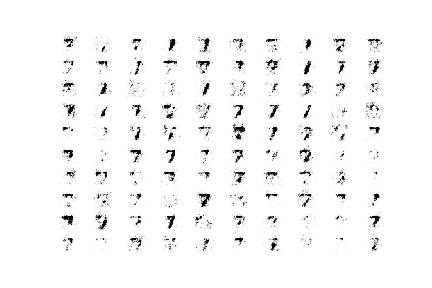

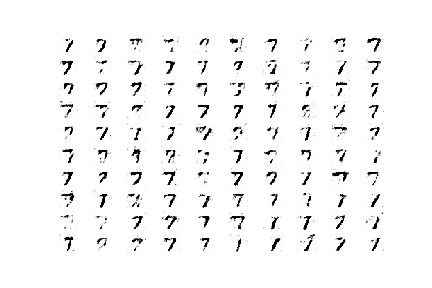